## Least Square demo

- See <http://www.efunda.com/math/leastsquares/leastsquares.cfm>
- See <http://www.lediouris.net/original/sailing/PolarCO2/index.html>

In [1]:
%classpath add jar "../build/libs/Algebra-1.0-all.jar"

In [2]:
import smoothing.LeastSquaresMethod;
import matrix.SquareMatrix;
import matrix.SystemUtil;

import gsg.SwingUtils.WhiteBoardPanel;
import gsg.VectorUtils;

import java.util.concurrent.atomic.AtomicInteger;
import java.awt.Color;
import java.awt.Dimension;
import java.awt.Font;

### Data, and resolution

In [3]:
final int REQUIRED_SMOOTHING_DEGREE = 3;

if (true) { // Turn to true to re-generate data
    BufferedWriter bw = new BufferedWriter(new FileWriter("cloud.csv"));
    LeastSquaresMethod.cloudGenerator(bw, -8, 28, 0.1, new double[] {3, 4, 5, 6, 9}, 0.001, -0.04, 0.2, 1);
    bw.close();
}

if (true) {
    LeastSquaresMethod.csvToJson("cloud.csv", "cloud.json");
}

List<LeastSquaresMethod.Tuple> data = new ArrayList<>();
BufferedReader br = new BufferedReader(new FileReader("cloud.csv"));
String line = "";
boolean go = true;
while (go) {
    line = br.readLine();
    if (line == null) {
        go = false;
    } else {
        String[] tuple = line.split(";");
        data.add(new LeastSquaresMethod.Tuple(Double.parseDouble(tuple[0]), Double.parseDouble(tuple[1])));
    }
}
br.close();

// Data is a list of Tuples
int dimension = REQUIRED_SMOOTHING_DEGREE + 1;
double[] sumXArray = new double[(REQUIRED_SMOOTHING_DEGREE * 2) + 1]; // Will fill the matrix
double[] sumY      = new double[REQUIRED_SMOOTHING_DEGREE + 1];
// Init
for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
    sumXArray[i] = 0.0;
}
for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
    sumY[i] = 0.0;
}

data.stream().forEach(tuple -> {
    for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
        sumXArray[i] += Math.pow(tuple.getX(), i);
    }
    for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
        sumY[i] += (tuple.getY() * Math.pow(tuple.getX(), i));
    }
});

SquareMatrix squareMatrix = new SquareMatrix(dimension);
System.out.println("\nMatrix Elements:");
for (int row=0; row<dimension; row++) {
    for (int col=0; col<dimension; col++) {
        int powerRnk = (REQUIRED_SMOOTHING_DEGREE - row) + (REQUIRED_SMOOTHING_DEGREE - col);
        System.out.println("[" + row + "," + col + ": degree " + (powerRnk) + "] = " + sumXArray[powerRnk]);
        squareMatrix.setElementAt(row, col, sumXArray[powerRnk]);
    }
}

System.out.println("\nConstants (column matrix):");
double[] constants = new double[dimension];
for (int i=0; i<dimension; i++) {
    constants[i] = sumY[REQUIRED_SMOOTHING_DEGREE - i];
    System.out.println("[" + (REQUIRED_SMOOTHING_DEGREE - i) + "] = " + constants[i]);
}

System.out.println("\nResolving this system:");
SystemUtil.printSystem(squareMatrix, constants);
System.out.println();

double[] result = SystemUtil.solveSystem(squareMatrix, constants);
System.out.println("\nResult (coeffs):");
String out = "[ ";
for (int i=0; i<result.length; i++) {
    out += String.format("%s%f", (i > 0 ? ", " : ""), result[i]);
}
out += " ]";
System.out.println(out);
// Nicer (Java 8 and after)
System.out.println();
AtomicInteger integer = new AtomicInteger(0);
Arrays.stream(result)
                .boxed()
                .map(coef -> new LeastSquaresMethod.IndexedCoeff(integer.incrementAndGet(), coef))
                .forEach(ic -> System.out.println(String.format("Deg %d -> %f", (dimension - ic.getIdx()), ic.getCoef())));


Y in [-12.307767, 9.393618]

Matrix Elements:
[0,0: degree 6] = 9.519328082242297E10
[0,1: degree 5] = 3.970587359699995E9
[0,2: degree 4] = 1.70908703994E8
[0,3: degree 3] = 7575929.999999995
[1,0: degree 5] = 3.970587359699995E9
[1,1: degree 4] = 1.70908703994E8
[1,2: degree 3] = 7575929.999999995
[1,3: degree 2] = 372602.99999999994
[2,0: degree 4] = 1.70908703994E8
[2,1: degree 3] = 7575929.999999995
[2,2: degree 2] = 372602.99999999994
[2,3: degree 1] = 17910.000000000004
[3,0: degree 3] = 7575929.999999995
[3,1: degree 2] = 372602.99999999994
[3,2: degree 1] = 17910.000000000004
[3,3: degree 0] = 1800.0

Constants (column matrix):
[3] = -2.241186121638433E7
[2] = -987774.0343944711
[1] = -39768.43230429998
[0] = -1900.4864879999961

Resolving this system:
(95193280822.422970 x A) + (3970587359.699995 x B) + (170908703.994000 x C) + (7575930.000000 x D) = -22411861.216384
(3970587359.699995 x A) + (170908703.994000 x B) + (7575930.000000 x C) + (372603.000000 x D) = -987774.034394

## Graphics

In [4]:
WhiteBoardPanel whiteBoard = new WhiteBoardPanel();
whiteBoard.setAxisColor(new Color(125, 0, 255, 255));
whiteBoard.setWithGrid(true);
whiteBoard.setBgColor(new Color(250, 250, 250, 255));
whiteBoard.setGraphicTitle("Least Squares");
whiteBoard.setSize(new Dimension(800, 600));
whiteBoard.setTextColor(Color.RED);
whiteBoard.setTitleFont(new Font("Arial", Font.BOLD | Font.ITALIC, 32));
whiteBoard.setGraphicMargins(30);
whiteBoard.setXEqualsY(false);

In [5]:
List<VectorUtils.Vector2D> cloudVectors = new ArrayList<>();

In [6]:
System.out.println(String.format("We have %d points in the cloud.", data.size()));
data.forEach(tuple -> {
    cloudVectors.add(new VectorUtils.Vector2D(tuple.getX(), tuple.getY()));
});

We have 1800 points in the cloud.


In [7]:
WhiteBoardPanel.DataSerie pointSerie = new WhiteBoardPanel.DataSerie()
                            .data(cloudVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.POINTS)
                            .circleDiam(6)
                            .color(Color.BLUE);
whiteBoard.addSerie(pointSerie);

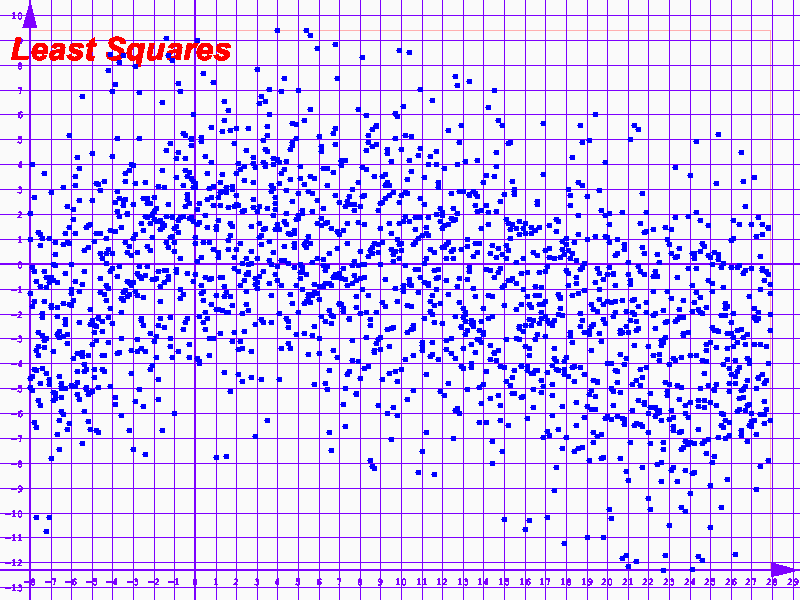

In [8]:
whiteBoard.getImage(); // This is for a Notebook

In [9]:
List<VectorUtils.Vector2D> function = new ArrayList<>();
for (double x=-10d; x<30d; x+=0.1) {
    function.add(new VectorUtils.Vector2D(x, LeastSquaresMethod.f(x, result)));
}

In [10]:
WhiteBoardPanel.DataSerie functionSerie = new WhiteBoardPanel.DataSerie()
                            .data(function)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.MAGENTA);
whiteBoard.addSerie(functionSerie);

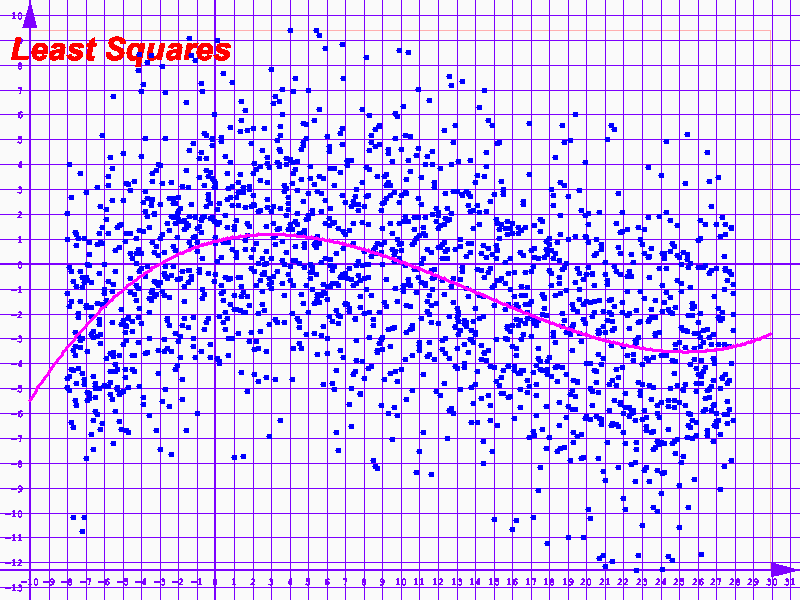

In [11]:
whiteBoard.getImage();

---